In [2]:
%matplotlib notebook
import numpy as np
import cupy as qp
import operator as op
import time
import matplotlib as mpl
from matplotlib import animation, rc
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive, Button
from IPython.display import display, HTML
import netCDF4 as nc

xp = np

In [3]:
# display functions

def disp3d(fig, aa, lines=(35,35)): # 3d wirefram plot
    # interpert inputs
    aa = qp.asnumpy(aa)
    
#     xlim = box[0]
#     ylim = box[1]
#     zlim = box[2]
#     if (xlim==None):
#         xlim = (0, aa[0].shape[0])
#     if (ylim==None): ylim = (0, aa[0].shape[1])
#     if (zlim==None):
#         ran = np.max(aa[0])-np.min(aa[0])
#         zlim = (np.min(aa[0])-ran, np.max(aa[0])+ran)
#         zlim = (-2, 2)
    
    #'wires' of the wireframe plot
    x = np.linspace(0, aa[0].shape[0]-1, lines[0], dtype=int)
    y = np.linspace(0, aa[0].shape[1]-1, lines[1], dtype=int)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    
    #display it
#     fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
#     for a in aa:
    A = aa#[xx,yy]
    ax.plot_wireframe(xx, yy, A)
    
    return ax



# def genframes(a, frames=120):#np.arange(120, dtype=int)):
#     arts = np.array([])#np.empty((frames.shape[0],))
# #     assert frames.dtype==int, "frames must be a numpy array of integers"
# #     frames = np.asarray(frames, dtype=int)
#     mm = np.max([-np.min(a), np.max(a)])/2
#     ds = a[np.linspace(0, a.shape[0]-1, frames, dtype=int)]
#     for d in ds:
# #         d = np.asarray(a[frame], dtype=np.float32) # data
#         im = plt.imshow(d, animated=True, vmin=-mm, vmax=mm, cmap='seismic')
#         arts = np.append(arts, im)
#     return f

# def motioncon(fig, f): # animated height plot, takes in list of 2d height arrays
    #prepare figure/display
    
#     z = qp.asnumpy(f[0])
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     mm = np.max([-np.min(f), np.max(f)])/2
#     im = ax.imshow(z, vmin=-mm, vmax=mm,cmap='seismic')
#     cb = fig.colorbar(im)
#     tx = ax.set_title(title)
#     plt.xticks(np.linspace(0, z.shape[0], xlabels.shape[0]), xlabels)
#     plt.yticks(np.linspace(0, z.shape[1], ylabels.shape[0]), ylabels)
    
#     def animate(i): # returns i'th element (height array) in f
#         im.set_data(qp.asnumpy(f[i]))
#         plt.contour(h, levels=1, cmap='gray')
    
    #display it
#     anim = animation.ArtistAnimation(fig, f)
#     return anim

def vect(u, v, arws=(10, 10), arwsz=100): # vector /motion plot
    #interpert inputs
    u = qp.asnumpy(u)
    v = qp.asnumpy(v)
#     if (xlim=='default'): xlim = (0, u.shape[0])
#     if (ylim=='default'): ylim = (0, v.shape[1])
    arws = (int(arws[0]), int(arws[1]))
    
    # set up
    x = np.linspace(0, u.shape[0]-1, arws[0], dtype=int)
    y = np.linspace(0, v.shape[1]-1, arws[1], dtype=int)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    uu = u[x,y]
    vv = v[x,y]
    m = np.hypot(uu, vv)
    
    #displat it
    q = plt.quiver(xx, yy, uu, vv, m, scale = 1/arwsz)
#     return ax
#     ax.set_xlim(xlim)
#     ax.set_ylim(ylim)
#     plt.title(title)
#     plt.show()

In [4]:
# useful math functions
def d_dx(a, dx):
    ddx = ( a[:-1] - a[1:] )*(-1/dx) 
    return ddx
def d_dy(a, dy):
    ddy = ( a[:,:-1] - a[:,1:] )*(-1/dy)
    return ddy
def div(u, v, dx, dy):
    div = d_dx(u, dx) + d_dy(v, dy)
    return div

# for generating simple environments or initial conditions
# def hydrodynamic
def planegauss(shape, win=((-2, 2), (-2, 2))):
   # h=np.empty(shape, dtype=np.float32)
    npx = np.linspace( win[0][0], win[0][1], shape[0] )
    npy = np.linspace( win[1][0],win[1][1], shape[1] )
    npxx, npyy = np.meshgrid(npx, npy, indexing='ij')
    h = np.exp( -np.e * ( npxx*npxx + npyy*npyy ) )
    return (h)
def lingauss(shape, w = 1/2, ax = 0, win = (-2, 2)):
   # h=np.empty(shape, dtype=np.float32)
    npx = np.linspace( win[0], win[1], shape[0] )
    npy = np.linspace( win[0], win[1], shape[1] )
    npxx, npyy = np.meshgrid(npy, npx)
    xy = (npyy, npxx)[ax]
    h = np.exp( -np.e * ( xy*xy ) / (w*w) )
    return (h)

In [277]:
# physics constants
class p():
    g = np.float32(9.81) # gravity

class State(): # state
    def __init__(self, h, n, u, v, dx, dy, lat, lon):
        
        self.dx = dx
        self.dy = dy
        self.lat = lat
        self.lon = lon
#         self.lats, self.lons = np.meshgrid(self.lat, self.lon)
#         self.lat, self.lon = np.meshgrid(self.lat, self.lon) # lattitude/longitude chunk simulation area stretches over
        self.h = h
    
        self.maxws = np.sqrt(np.max(self.h)*p.g) # maximum wave speed
        
        self.n = np.asarray(n, dtype=np.float32) # surface height (eta)
        self.u = np.asarray(u, dtype=np.float32) # x vel array
        self.v = np.asarray(v, dtype=np.float32) # y vel array
        
        #make sure h is the same shap as n (eta)
        assert (np.isscalar(h) or self.h.shape == self.n.shape), "H and N must have the same shape, or H must be a scalar" # 'or' is short circuit
        
#         self.calcDt()
        self.dt = np.min((np.min(self.dx), np.min(self.dy)))/(5*self.maxws)
        
        self.coriolis = ((2*2*np.pi*np.sin(self.lat*np.pi/180))/(24*3600))[:,np.newaxis] # rotation speed of the earth dtheta/dt
        """ derivation of coriolis force
        U = R*cos(phi)*O
        ui = U+ur
        ur = ui-U
        dU/dphi = -R*sin(phi)*O
        phi = y/R
        dphi/dt = v/R
        dU/dt = v*(-sin(phi)*O)
        dur/dt = dui/dt - dU/dt = v*O*sin(phi)
        dur/dt = v*O*sin(phi)"""
        self.movetodevice()
    def movetodevice(self):
        self.lat = xp.asarray(self.lat)
        self.lon = xp.asarray(self.lon)
        self.h = xp.asarray(self.h)
        self.n = xp.asarray(self.n)
        self.u = xp.asarray(self.u)
        self.v = xp.asarray(self.v)
        self.coriolis = xp.asarray(self.coriolis)
#     def calcDt(self, fudge = 5): #calculate optimal value of dt for the height and dx values
#         dx = np.min(self.dx)
#         dy = np.min(self.dy)
#         self.dt = np.min((dx, dy))/(fudge*self.maxws)
props = op.itemgetter('h', 'n', 'u', 'v', 'dx', 'dy', 'lat', 'lon') # for grrabbing the elements of a state
# def newstate(state):
#     return State(*(props(vars(state))))


# physics shallow water framework

## Class of objects to hold current state of an ocean grid 

Equations of motion
$$
\begin{align}
\frac{\partial n}{\partial t} & = -\frac{\partial  }{\partial x} \bigl( \left( n+h\right)u \bigr) - \frac{\partial  }{\partial y}  \bigl( \left( n+h\right)v \bigr)\\
\frac{\partial u}{\partial t} & = -u\frac{\partial u}{\partial x} - v\frac{\partial u}{\partial y} +fv - g\frac{\partial n}{\partial x}\\
\frac{\partial v}{\partial t} & = -u\frac{\partial v}{\partial x} - v\frac{\partial v}{\partial y} -fv - g\frac{\partial n}{\partial x}
\end{align}
$$

Where 
- *_h_* calm ocean depth (positive number) at any point. Presumed constant
- *_n_* is the wave height above the calm ocean height
- *_u_* is the mean water column velocity in the _x_ (east) direction
- *v* is the mean water column velocity in the _y_ (north) direction

and the physcial constant parameters are:
- *g* gravitational constant
- *f* is the lattidude dependent coriolis coefficient: $2\omega \sin(latitude)$


In [238]:
def dndt(h, n, u, v, dx, dy) : # for individual vars
# def dndt(state):
    """change in n per timestep, by diff. equations"""
#     h, n, u, v, dx, dy = [qp.asnumpy(state.__dict__[k]) for k in ('h', 'n', 'u', 'v', 'dx', 'dy')]
    hx = xp.empty(u.shape, dtype=n.dtype) # to be x (u) momentum array
    hy = xp.empty(v.shape, dtype=n.dtype)
    
    depth = h+n
    hx[1:-1] = (depth[1:] + depth[:-1])/2 # average to same shape as u
    hx[0] = depth[0]#*2-depth[1] # normal flow boundaries/borders
    hx[-1] = depth[-1]#*2-depth[-2] # the water exiting the water on the edge is n+h
    
    hy[:,1:-1] = (depth[:,1:] + depth[:,:-1])/2
    hy[:,0] = depth[:,0]#*2-depth[:,1]
    hy[:,-1] = depth[:,-1]#*2-depth[:,-2]
    
    hx *= u # height/mass->momentum of water column.
    hy *= v
#     dndt = d_dx(hx, -dx)+d_dy(hy, -dy)#(div(hx, hy, -dx, -dy))
    return ( d_dx(hx, -dx)+d_dy(hy, -dy) )
 # change in x vel. (u) per timestep
    
countx=0
    
def dudt(h, n, f, u, v, dx, dy, mu=0.3) : # for individual vars
# def dudt(state):
#     f, n, u, v, dx, dy = [qp.asnumpy(state.__dict__[k]) for k in ('coriolis', 'n', 'u', 'v', 'dx', 'dy')]
    dudt = xp.empty(u.shape, dtype=u.dtype) # x accel array
    grav = d_dx(n, -dx/p.g)
    dudt[1:-1] = grav
    dudt[0] = grav[0]*2-grav[1] # assume outside map wave continues with constant slope
    dudt[-1] = grav[-1]*2-grav[-2]
    
    
    # coriolis force
    vn = (v[:,1:]+v[:,:-1])*0.5 # n shaped v
    
    fn = f#(f[:,1:]+f[:,:-1])*0.5 # n shaped f
    fvn = (fn*vn) # product of coriolis and y vel.
    dudt[1:-1] += (fvn[1:]+fvn[:-1])*0.5 # coriolis force
    dudt[0] += fvn[0]
    dudt[-1] += fvn[-1]
    
    
    
#     if ( np.any([np.isnan(u), np.isinf(u)])):
#         print('found nan or inf u')
    

#     advecx = 
    
#     global countx
#     if countx%10 == 0:
#         print('advec:' + str(advecx[238:250, 154:158]))
#         print('dudt-advec:' + str(dudt[238:250, 154:158]))
#         print('n' + str(n[238:250, 154:158]))
#         print('v' + str(v[238:250, 154:158]))
#         print('u' + str(u[238:250, 154:158]))
#         print('du' + str(dudx[238:250, 154:158]))
#         print("-----------")
#         countx=0
#     countx +=1    
#     if ( np.any([np.isnan(advecx), np.isinf(advecx)])):
#         print('found nan or inf advecx')
#         infloc = np.where(np.isinf(advecx))
#         print(infloc, advecx[infloc])
#         nanloc = np.where(np.isnan(advecx))
#         print(nanloc, advecx[nanloc])
#         print(advecx[238:250, 154:159])
#         print('n' + str(n[238:250, 154:158]))
#         print('v' + str(v[238:250, 154:158]))
#         print(u[238:250, 154:159])
#         print(dudx[238:250, 154:159])
#         raise Exception('a nan or infinity value happened in advecx, in dudt')
    
    
    
    
    # advection
    
    # advection in x direction
    dudx = d_dx(u, dx)
    
    dudt[1:-1] -= u[1:-1]*(dudx[1:] + dudx[:-1])*0.5 # advection
    dudt[0] -= u[0]*dudx[0]
    dudt[-1] -= u[-1]*dudx[-1]
    
    # advection in y direction
    duy = xp.empty(u.shape, dtype=u.dtype)
    dudy = d_dy(u, dy)
    duy[:,1:-1] = ( dudy[:,1:] + dudy[:,:-1] ) * 0.5
    duy[:,0] = dudy[:,0]
    duy[:,-1] = dudy[:, -1]
    dudt[1:-1] -= (vn[1:]+vn[:-1])*0.5*duy[1:-1] # advection
    dudt[0] -= vn[0]*duy[0]
    dudt[-1] -= vn[-1]*duy[-1] # closest to applicable position
    
    
    
#     if ( np.any([np.isnan(advecy), np.isinf(advecy)])):
#         print('found nan or inf advecy')
#      -= advecy
    
#     una = (u[1:]+u[:-1]) * 0.5
#     vna = (v[:,1:]+v[:,:-1])*0.5
#     attenu = 1/(h+n) * mu * una * np.sqrt(una*una + vna*vna) # attenuation
#     dudt[1:-1] -= (attenu[1:] + attenu[:-1])*0.5
    
    
    # viscous term
    nu = 1000/dx
    ddux = d_dx(dudx, dx)
    dduy = xp.empty(u.shape, dtype=u.dtype)
    ddudy = d_dy(duy, dy)
    dduy[:,1:-1] = ( ddudy[:,1:] + ddudy[:,:-1] ) * 0.5
    dduy[:,0] = ddudy[:,0]
    dduy[:,-1] = ddudy[:, -1]
    dudt[1:-1] += nu*(ddux+dduy[1:-1])
    dudt[0] += nu*ddux[0]*dduy[0]
    dudt[-1] += nu*ddux[-1]*dduy[-1]
    
    
#     dudt[0] = dudt[-1] = 0 # reflective boundaries
    return ( dudt )
def dvdt(h, n, f, u, v, dx, dy, mu=0.3) :
# def dvdt(state):
#     f, n, u, v, dx, dy = [qp.asnumpy(state.__dict__[k]) for k in ('coriolis', 'n', 'u', 'v', 'dx', 'dy')]
    #
    dvdt = xp.empty(v.shape, dtype=v.dtype) # x accel array
    grav = d_dy(n, -dy/p.g)
    dvdt[:,1:-1] = grav
    dvdt[:,0] = grav[:,0]*2-grav[:,1] # assume outside map wave continues with constant slope
    dvdt[:,-1] = grav[:,-1]*2-grav[:,-2]
    
    
    # coriolis force
    un = (u[1:]+u[:-1])*0.5 # n-shaped u
    
    fun = (f*un) # product of coriolis and x vel.
    dvdt[:,1:-1] += (fun[:,1:]+fun[:,:-1])*0.5 # coriolis force
    dvdt[:,0] += fun[:,0]
    dvdt[:,-1] += fun[:,-1]
    
    
    
#     if ( np.any([np.isnan(u), np.isinf(u)])):
#         print('found nan or inf u')
    

#     advecx = 
    
#     global countx
#     if countx%10 == 0:
#         print('advec:' + str(advecx[238:250, 154:158]))
#         print('dudt-advec:' + str(dudt[238:250, 154:158]))
#         print('n' + str(n[238:250, 154:158]))
#         print('v' + str(v[238:250, 154:158]))
#         print('u' + str(u[238:250, 154:158]))
#         print('du' + str(dudx[238:250, 154:158]))
#         print("-----------")
#         countx=0
#     countx +=1    
#     if ( np.any([np.isnan(advecx), np.isinf(advecx)])):
#         print('found nan or inf advecx')
#         infloc = np.where(np.isinf(advecx))
#         print(infloc, advecx[infloc])
#         nanloc = np.where(np.isnan(advecx))
#         print(nanloc, advecx[nanloc])
#         print(advecx[238:250, 154:159])
#         print('n' + str(n[238:250, 154:158]))
#         print('v' + str(v[238:250, 154:158]))
#         print(u[238:250, 154:159])
#         print(dudx[238:250, 154:159])
#         raise Exception('a nan or infinity value happened in advecx, in dudt')
    
    
    
    
    # advection
    
    # advection in y direction
    dvdy = d_dy(v, dy)
    
    dvdt[:,1:-1] -= v[:,1:-1]*(dvdy[:,1:] + dvdy[:,:-1])*0.5 # advection
    dvdt[:,0] -= v[:,0]*dvdy[:,0]
    dvdt[:,-1] -= v[:,-1]*dvdy[:,-1]
    
    # advection in x direction
    dvx = xp.empty(v.shape, dtype=v.dtype)
    dvdx = d_dx(v, dx)
    dvx[1:-1] = ( dvdx[1:] + dvdx[:-1] ) * 0.5
    dvx[0] = dvdx[0]
    dvx[-1] = dvdx[-1]
    dvdt[:,1:-1] -= (un[:,1:]+un[:,:-1])*0.5*dvx[:,1:-1] # advection
    dvdt[:,0] -= un[:,0]*dvx[:,0]
    dvdt[:,-1] -= un[:,-1]*dvx[:,-1] # closest to applicable position
    
    
    
#     if ( np.any([np.isnan(advecy), np.isinf(advecy)])):
#         print('found nan or inf advecy')
#      -= advecy
    
#     una = (u[1:]+u[:-1]) * 0.5
#     vna = (v[:,1:]+v[:,:-1])*0.5
#     attenu = 1/(h+n) * mu * una * np.sqrt(una*una + vna*vna) # attenuation
#     dudt[1:-1] -= (attenu[1:] + attenu[:-1])*0.5
    
    
    # viscous term
    nu = 1000/dy
    ddvy = d_dy(dvdy, dy)
    ddvx = xp.empty(v.shape, dtype=v.dtype)
    ddvdx = d_dx(dvx, dx)
    ddvx[1:-1] = ( ddvdx[1:] + ddvdx[:-1] ) * 0.5
    ddvx[0] = ddvdx[0]
    ddvx[-1] = ddvdx[-1]
    dvdt[:,1:-1] += nu*(ddvy+ddvx[:,1:-1])
    dvdt[:,0] += nu*ddvx[:,0]*ddvy[:,0]
    dvdt[:,-1] += nu*ddvx[:,-1]*ddvy[:,-1]
    
    return dvdt

def land(h, u, v, thresh = 100): # how to handle land/above water area
    #boundaries / land
    coastx = xp.less(h, thresh) # start a little farther than the coast so H+n is never less than zero
    (u[1:])[coastx] = (u[:-1])[coastx] = 0 # set vel. on either side of land to zero, makes reflective
    (v[:,1:])[coastx] = (v[:,:-1])[coastx] = 0
    return (u, v)

In [241]:
def forward(h, n, u, v, f, dt, dx, dy, doland, landthresh, beta=0, mu=0.3): # forward euler and forward/backward timestep
    # beta = 0 - forward, beta = 1 - forward-backward
    n1 = n + ( dndt(h, n, u, v, dx, dy) )*dt
#     if ( np.any([np.isnan(n1), np.isinf(n1)])):#np.any(n1[np.logical_not(coastx)]>h[np.logical_not(coastx)]) ):#np.sum((n1[coastx]-h[coastx])>0)>0 ):
# #     if( np.any(np.logical_and( n1>h, np.logical_not(coastx))) ):
#         print('found nan or inf in n1 ')
    u1 = u + ( beta*dudt(h, n1, f, u, v, dx, dy, mu) +  (1-beta)*dudt(h, n, f, u, v, dx, dy, mu) )*dt
    v1 = v + ( beta*dvdt(h, n1, f, u, v, dx, dy, mu) +  (1-beta)*dvdt(h, n, f, u, v, dx, dy, mu) )*dt
    u1, v1 = doland(h, u1, v1, landthresh) # handle any land in the simulation
    n1[0:10] *= 0.9
    n1[-1:-11:-1] *= 0.9
    n1[:,0:10] *= 0.9
    n1[:,-1:-11:-1] *= 0.9
    return n1, u1, v1

def fbfeedback(h, n, u, v, f, dt, dx, dy, doland, landthresh, beta=1/3, eps=2/3, mu=0.3): # forward backward feedback timestep
    n1g, u1g, v1g = forward(h, n, u, v, f, dt, dx, dy, doland, landthresh, beta, mu) # forward-backward first guess
    #feedback on guess
    n1 = n + 0.5*(dndt(h, n1g, u1g, v1g, dx, dy) + dndt(h, n, u, v, dx, dy))*dt
    u1 = u + 0.5*(eps*dudt(h, n1, f, u, v, dx, dy, mu)+(1-eps)*dudt(h, n1g, f, u1g, v1g, dx, dy, mu)+dudt(h, n, f, u, v, dx, dy, mu))*dt
    v1 = v + 0.5*(eps*dvdt(h, n1, f, u, v, dx, dy, mu)+(1-eps)*dvdt(h, n1g, f, u1g, v1g, dx, dy, mu)+dvdt(h, n, f, u, v, dx, dy, mu))*dt
    u1, v1 = doland(h, u1, v1, landthresh) # how to handle land/coast
    
#     coastx = np.less(h, 100)
#     global countx
#     if countx%10==0:
#         print ("XXXXXXXXXXXXXXXX  minimum n",np.min(n1),np.argmin(n1))
#     if (np.any(n1 < -1.0E4)):
        
#         infloc = np.where(np.logical_and((n1+h) < 0,np.logical_not(coastx)))
#         print("n is deeper than h !!!!!!!!",infloc)
#         print('n' + str(n1[238:250, 154:158]))
#         print('v' + str(v1[238:250, 154:158]))
#         print(u1[238:250, 154:159])
 
#         raise Exception('n is deeper than h !!!!!!!!"')
        
#     if ( np.any([np.isnan(n1), np.isinf(n1)])):#np.any(n1[np.logical_not(coastx)]>h[np.logical_not(coastx)]) ):#np.sum((n1[coastx]-h[coastx])>0)>0 ):
#     if( np.any(np.logical_and( n1>h, np.logical_not(coastx))) ):
#         print('found nan or inf in n or h')
#         raise Exception('n hit infinity or nan')
#         print('n > h at ' + str(np.where( np.logical_and( n1>h, np.logical_not(coastx)) )) )
#         print('\n\n')
        
    
#     print(np.sum(np.abs(n[coastx])), np.sum(np.abs(h[coastx])), end='\r')
    n1[0:10] *= 0.9
    n1[-1:-11:-1] *= 0.9
    n1[:,0:10] *= 0.9
    n1[:,-1:-11:-1] *= 0.9
    return n1, u1, v1


# versions using STATE class

# def forward(state, doland, beta=0): # forward euler and forward/backward timestep
#     # beta = 0 - forward, beta = 1 - forward-backward
#     h, n, u, v, dx, dy, dt = [qp.asnumpy(state.__dict__[k]) for k in ('h', 'n', 'u', 'v', 'dx', 'dy', 'dt')]
#     nstate = newstate(state)
#     nstate.n = n + ( dndt(state) )*dt
#     u1 = u + ( beta*dudt(nstate) +  (1-beta)*dudt(state) )*dt
#     v1 = v + ( beta*dvdt(nstate) +  (1-beta)*dvdt(state) )*dt
#     u1, v1 = doland(state.h, u1, v1) # handle any land in the simulation
#     return nstate.n, u1, v1


# def fbfeedback(state, doland, beta=1/3, eps=2/3): # forward backward feedback timestep
#     h, n, u, v, dx, dy, dt = [qp.asnumpy(state.__dict__[k]) for k in ('h', 'n', 'u', 'v', 'dx', 'dy', 'dt')]
#     pstate = newstate(state) # predictor state, rough approx. with forward/backward
#     pstate.n, pstate.u, pstate.v = forward(state, doland, beta) # forward-backward first guess
#     #feedback on guess
#     nstate = newstate(state)
#     nstate.n = n + 0.5*(dndt(pstate) + dndt(state))*dt
#     u1 = u + 0.5*(eps*dudt(nstate)+(1-eps)*dudt(pstate)+dudt(state))*dt
#     v1 = v + 0.5*(eps*dvdt(nstate)+(1-eps)*dvdt(pstate)+dvdt(state))*dt
#     u1, v1 = doland(state.h, u1, v1) # how to handle land/coast
#     return nstate.n, u1, v1



def timestep(h, n, u, v, f, dt, dx, dy, landthresh, mu): return fbfeedback(h, n, u, v, f, dt, dx, dy, land, landthresh, mu) # switch which integrator/timestep is in use
# def timestep(state): return fbfeedback(state, land) # which integrator/timestep is in use

#

In [9]:
def simulate(initstate, t, ffs = 120, mu=0.3): # gives surface height array of the system after evert dt
    h, n, u, v, f, dx, dy, dt = [qp.asnumpy(initstate.__dict__[k]) for k in ('h', 'n', 'u', 'v', 'coriolis', 'dx', 'dy', 'dt')]#h, state.n, state.u, state.v, state.dx, state.dy, state.dt
    state = initstate
    landthresh = 1.5*np.max(n) # threshhold for when sea ends and land begins
    assert (dt >= 0), 'negative dt!' # dont try if timstep is zero or negative
#     ff = itrs//1000 + 1 # frequency of snapshots taken into time array, to prevent memory error
    nt = np.empty((ffs,)+n.shape, dtype=n.dtype) # list of height arrays over time # (int(np.ceil(itrs/100)) #int(np.ceil(itrs/ff))
    maxn = np.zeros(n.shape, dtype=n.dtype) # max height in that area
    minn = np.zeros(n.shape, dtype=n.dtype) # minimum height that was at each point
    timemax = np.zeros(n.shape, dtype=n.dtype) # when the maximum height occured
    ind = 0
    itrs = int(np.ceil(t/dt))
    ff = itrs/(ffs) # number of iterations between frames
#     starttime = time.process_time()
#     for x in range(10):
#         timestep(h, n, u, v, f, dt, dx, dy)
#     timeperts = (time.process_time() - starttime )*0.1
#     for af in range(ffs):
    try:
        for itr in range(itrs):# iterate for the given number of iterations
            n, u, v = timestep(h, n, u, v, f, dt, dx, dy, landthresh, mu) # pushes n, u, v one step into the future
            maxn = np.max((n, maxn), axis=0) # record new maxes if they are greater than previous records
            minn = np.min((n, minn), axis=0)
            timemax[np.greater(n, maxn)] = itr*dt
            nt[int(np.floor(itr/ff))] = qp.asnumpy(n) # add a new snapshot of the surface height for every frame # every ff iteration
    #         print('['+int(np.round(30*itr/itrs))*'='+'>'+ int(30-np.round(30*itr/itrs))*' '+'] ' \
    #                + str(np.round(100*itr/itrs, 3))+'% ETA: '+str(np.round(timeperts*(itrs-itr), 2))+'s'+10*' ', end='\r')
            #             ind+=1# add new surface height to array
    except:
        print('timestep #:' + str(itr))
        raise Exception('error occured in simulate, printed timestep#')
    print()
    print('simulation finished')
    return {'frames':nt, 'max':maxn, 'min':minn, 'time':timemax} # return surface height through time and maximum heights

# verification

In [10]:
#wavespeed and differential tests
import unittest
fooo = []
class testWaveSpeed(unittest.TestCase): # tests if the wave speed is correct
    def setUp(self):
        self.dur = 500 # duration of period to calculate speed over
        self.size = (10, 1000) # grid squares (dx's)
        self.dx = np.single(100, dtype=np.float32) # meters
        self.dy = np.single(100, dtype=np.float32)
        self.lat = np.linspace(0, 0, self.size[0]) # physical location the simulation is over
        self.lon = np.linspace(0, 0 , self.size[1])
        self.h = 100
        self.n = 1*lingauss(self.size, 1/4, 1) # intial condition single wave in the center
        self.u = np.zeros((self.size[0]+1, self.size[1]+0)) # x vel array
        self.v = np.zeros((self.size[0]+0, self.size[1]+1)) # y vel array
        self.margin = 0.1 # error margin of test
    def calcWaveSpeed(self, ar1, ar2, Dt): # calculat how fast the wave is propagating out
        midstrip1 = ar1[int(ar1.shape[0]/2),int(ar1.shape[1]/2):]
        midstrip2 = ar2[int(ar1.shape[0]/2),int(ar2.shape[1]/2):]
        peakloc1 = np.argmax(midstrip1)
        peakloc2 = np.argmax(midstrip2)
        plt.figure(1)
        plt.clf()
        plt.plot(midstrip1)
        plt.plot(midstrip2)
        plt.show()
        speed = (peakloc2 - peakloc1)*self.dy/Dt
        return speed
    def calcExactWaveSpeed(self): # approximently how fast the wave should be propagating outwards
        ws = np.sqrt(p.g*np.average(self.h))
        return ws
    def test_wavespeed(self): # test if the expected and calculated wave speeds line up approcimently
        self.testStart = State(self.h, self.n, self.u, self.v, self.dx, self.dy, self.lat, self.lon)
        self.simdata = simulate(self.testStart, self.dur)
#         self.testFrames, self.testmax, self.testmin = self.simdata[:3]
        self.testFrames = self.simdata['frames']
        self.testEndN = self.testFrames[-1]
        calcedws = self.calcWaveSpeed( self.testStart.n, self.testEndN, self.dur )
        exactws = self.calcExactWaveSpeed()
        err = (calcedws - exactws)/exactws
        print(err, self.margin)
        assert(abs(err) < self.margin) # error margin
    def tearDown(self):
        del(self.dur)
        del(self.dx)
        del(self.dy)
        del(self.lat)
        del(self.lon)
        del(self.size)
        del(self.h)
        del(self.n)
        del(self.u)
        del(self.v)

class testdifferential(unittest.TestCase): # differental function test (d_dx)
    def setUp(self):
        self.a = np.arange(144) # test input
        self.a = self.a.reshape(12, 12) # make into 2d array
        self.ddthreshold = 1E-16
    def test_ddx(self):
        da = d_dx(self.a, 1)
        diff = np.abs(da[1:-1] - np.mean(da[1:-1]))
        maxdiff = np.max(diff)
        self.assertTrue(np.all(np.abs(da[-1:1] < self.ddthreshold)),"expected zero along borders")
        self.assertTrue(np.all(diff < self.ddthreshold),"Expected constant d_dx less than %f but got %f"%(self.ddthreshold,maxdiff))
    def tearDown(self):
        del(self.a)
        del(self.ddthreshold)

unittest.main(argv=['first-arg-is-ignored'], exit=False)
#You can pass further arguments in the argv list, e.g.
#unittest.main(argv=['ignored', '-v'], exit=False)      
#unittest.main()

E.

timestep #:0



ERROR: test_wavespeed (__main__.testWaveSpeed)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-9-3546e71566ab>", line 21, in simulate
    n, u, v = timestep(h, n, u, v, f, dt, dx, dy, landthresh, mu) # pushes n, u, v one step into the future
  File "<ipython-input-8-19c34c17e2ee>", line 73, in timestep
    def timestep(h, n, u, v, f, dt, dx, dy, landthresh, mu): return fbfeedback(h, n, u, v, f, dt, dx, dy, land, landthresh, mu) # switch which integrator/timestep is in use
  File "<ipython-input-8-19c34c17e2ee>", line 13, in fbfeedback
    n1g, u1g, v1g = forward(h, n, u, v, f, dt, dx, dy, doland, landthresh, beta, mu) # forward-backward first guess
  File "<ipython-input-8-19c34c17e2ee>", line 3, in forward
    n1 = n + ( dndt(h, n, u, v, dx, dy) )*dt
  File "<ipython-input-6-35115c53bf08>", line 9, in dndt
    hx[0] = h[0]+n[0] # normal flow boundaries/borders
IndexError: too many indices for array

Duri

In [242]:
simpletestcase = {
    'h': 1000*np.ones((100, 100), dtype=np.float),
    'n': planegauss((100, 100), ((-4, 4),(-4,4))),
    'u': np.zeros((101, 100)),
    'v': np.zeros((100, 101)),
    'dx': 100,
    'dy': 100,
    'lat': np.zeros((100,)),
    'lon': np.zeros((100,))
}
simpleState = State(**simpletestcase)
simpleframes = simulate(simpleState, 200, 200)['frames']#, simpleMax, simpleMin, simpleAT

# fig = plt.figure(23)
# plt.imshow(simpleframes[50])v


simulation finished


<IPython.core.display.Javascript object>


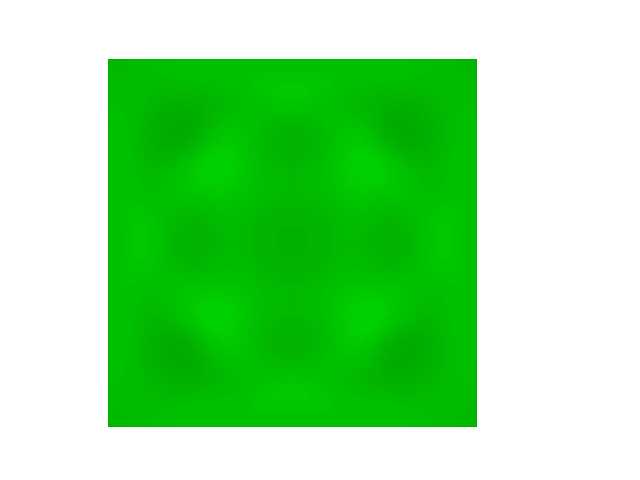

In [243]:
fig = plt.figure(25)
mmax = np.max(np.abs(simpleframes))/2
simpleart = [(plt.imshow(simplef, vmin=-mmax, vmax=mmax, cmap='nipy_spectral'),) for simplef in simpleframes]
anim = animation.ArtistAnimation(fig, simpleart, interval=50, blit=True, repeat_delay=200)
plt.colorbar()
plt.show()


In [14]:
friccase = {
    'h': 1000,#*np.ones((100, 100), dtype=np.float),
    'n': planegauss((100, 100)),
    'u': np.zeros((101, 100)),
    'v': np.zeros((100, 101)),
    'dx': 100,
    'dy': 100,
    'lat': np.zeros((100,)),
    'lon': np.zeros((100,))
}
fricState = State(**friccase)
fricframes = simulate(fricState, 100, 100)['frames']#, simpleMax, simpleMin, simpleAT
nofricframes = simulate(fricState, 100, 100, 0.0)['frames']
# fig = plt.figure(23)
# plt.imshow(simpleframes[50])v

/home/rrs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in sqrt
/home/rrs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in sqrt



simulation finished

simulation finished


In [15]:
fig = plt.figure(25)
fricdif = (fricframes-nofricframes)/(np.abs(fricframes)+np.abs(nofricframes)+1E-10)
fricart = [(plt.imshow(fricf, vmin=np.min(fricdif), vmax=np.max(fricdif)),) for fricf in fricdif]
anim = animation.ArtistAnimation(fig, fricart, interval=50, blit=True, repeat_delay=0)
plt.colorbar()
plt.show()
print(np.mean(fricdif))

0.00028778389


# indonesian tsunami

In [16]:

class indone2004():
    event = {
        'lat': 3.316,
        'lon': 95.854
    } # source of the tsunami
    
    dlat = 111000 # latitude degree to meters
    psize = (dlat*30*np.cos(22.5*np.pi/180), dlat*15) # physical size of area
    size = (2500, 1250) # grid squares (dx) # lat, lon

    dx = np.single(psize[0]/size[0], dtype=np.float32) # meters
    dy = np.single(psize[1]/size[1], dtype=np.float32) # meters

    
    bath = nc.Dataset('../data/bathymetry.nc','r')
    
    rxy = (8, 16)
    lat = bath.variables['lat'][:]#[latin]
    lon = bath.variables['lon'][:]
    latr = (np.abs(lat-event['lat']+rxy[1]).argmin(), np.abs(lat-event['lat']-rxy[1]).argmin())
    lonr = (np.abs(lon-event['lon']+rxy[0]).argmin(), np.abs(lon-event['lon']-rxy[0]).argmin())
    latin = np.linspace(latr[0], latr[1], size[0], dtype=int)
    lonin = np.linspace(lonr[0], lonr[1], size[1], dtype=int) # indexes of the bathymetry dataset we need
    lat = bath.variables['lat'][latin]
    lon = bath.variables['lon'][lonin]
    h = np.asarray(-bath.variables['elevation'][latin, lonin], dtype=np.float32)

    n = np.zeros(size)

    evinlat = np.argmin(np.abs(lat - event['lat']))
    evinlon = np.argmin(np.abs(lon - event['lon'])) # the index of the closest value to the correct longitude
    rady = 1+2*(int(25000/dy)//2) # number of indicies across the disturbance is
    radx = 1+2*(int(25000/dx)//2) # modified to be odd, so a point lands on the max of the gaussian
#     evpatch = \

#     evpatch = \
    n[evinlat-rady:evinlat+rady, evinlon-radx:evinlon+radx] = \
    50*planegauss((2*rady, 2*radx))

    u = np.zeros((size[0]+1, size[1]+0))
    v = np.zeros((size[0]+0, size[1]+1))

indonesia = State(*(props(vars(indone2004))))

<IPython.core.display.Javascript object>


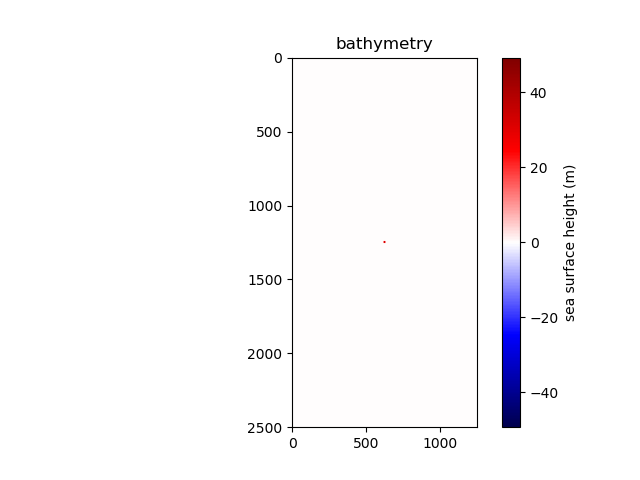

/home/rrs/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


In [19]:
seasurface = qp.asnumpy(indonesia.n)#np.empty(qp.asnumpy(indonesia.n).shape)
# seasurface[::-1] = qp.asnumpy(indonesia.n)
bathymetry = -qp.asnumpy(indonesia.h)


plt.figure(116)
plt.title('initial conditions of indonesia simulation')

# plt.subplot(121)
a1 = plt.imshow(seasurface, cmap='seismic', vmin=-np.max(seasurface), vmax=np.max(seasurface))
tt1 = plt.title('initial sea surface height')
cb1 = plt.colorbar()
cb1.set_label('sea surface height (m)')

# plt.subplot(222)
a2 = plt.contour(-bathymetry, cmap='Greys')
tt2 = plt.title('bathymetry')
# cb2 = plt.colorbar()
# cb2.set_label('ocean depth (m)')

# plt.subplot(122)
# # a3 = vect()
# tt3 = plt.title('inital velocity (m/s)')


In [132]:
indosim = simulate(indonesia, 2500)
indot = indosim['frames']
maxindo = indosim['max']
minindo = indosim['min']
tmindo = indosim['time']

KeyboardInterrupt: 

masq = np.zeros(qp.asnumpy(indonesia.h).shape, dtype=qp.asnumpy(indonesia.h).dtype)
runuplocs = np.array([(5.251, 95.253), (5.452, 95.242), (5.389, 95.960), (2.575, 96.269), (4.208, 96.040)])
radx = masq.shape[0]//100
rady = masq.shape[1]//100
for runuploc in runuplocs:
    arglat, arglon = np.argmin(np.abs(indonesia.lat-runuploc[0])), np.argmin(np.abs(indonesia.lon-runuploc[1])) # gat the index location of this event
    masq[arglat-radx:arglat+radx, arglon-rady:arglon+rady] = 1 # make a small blip around the locatoin

plt.figure(123)
plt.contour(masq)
plt.show()

In [14]:
# shallowWater/data/2004indonesiarunups.txt

In [15]:
indof = np.transpose(indot, (0, 1, 2))
print(indof.shape)
maxt = np.max(indof,axis=(1,2))
print(maxt.shape)
imaxt = np.float32(1.0/maxt)
# plt.figure(888)
# plt.semilogy(maxt)
# plt.show()
norm_indof = indof*imaxt[:,np.newaxis,np.newaxis]

h = qp.asnumpy(indonesia.h)
# ht = np.transpose(h)
ht = h

(120, 2500, 1250)
(120,)


<IPython.core.display.Javascript object>


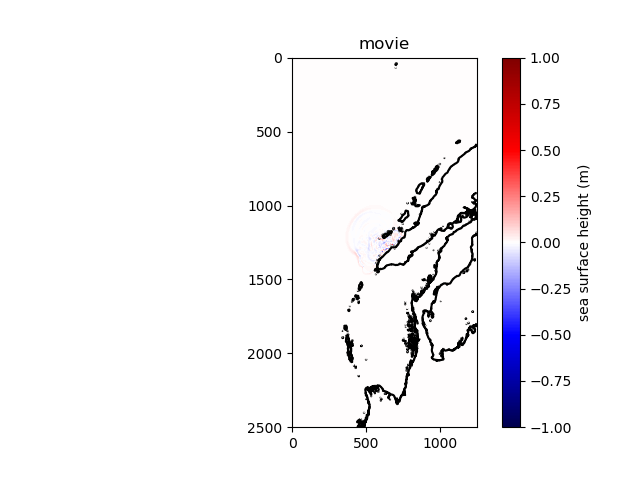

In [16]:
fig = plt.figure(122)

# plt.subplot(1, 3, 1)
plt.title('movie')
# f = genframes(norm_indof*0.3, frames=np.linspace(0, norm_indof.shape[0]-1, 300, dtype=int))
indoArts = [(plt.imshow(normindoframe, cmap='seismic', vmin=-np.max(normindoframe), vmax=np.max(normindoframe)),) for normindoframe in norm_indof]
indoAnim = animation.ArtistAnimation(fig, indoArts)
cb = plt.colorbar()
cbtt = cb.set_label('sea surface height (m)')


coast = plt.contour(ht, colors='black', levels=1)#, levels=3)
# locmask = plt.contour(masq, colors='green', levels=2)

<IPython.core.display.Javascript object>


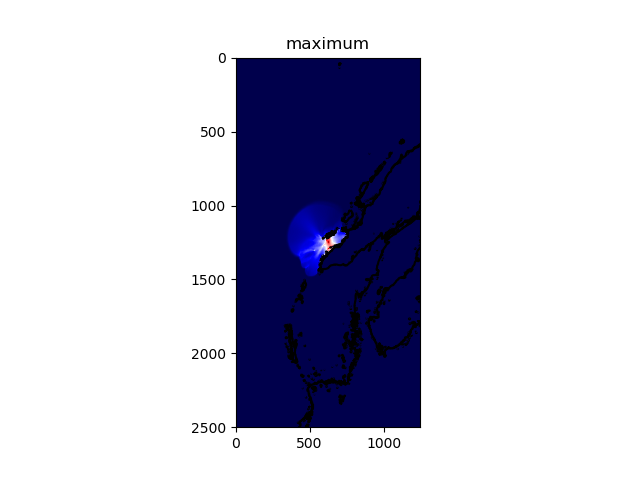

In [17]:
fig = plt.figure(124)
plt.title('maximum')
plt.imshow(maxindo+1, cmap='seismic', norm=mpl.colors.LogNorm())
# plt.colorbar()
plt.contour(ht-20, colors='black', levels=1)

<IPython.core.display.Javascript object>


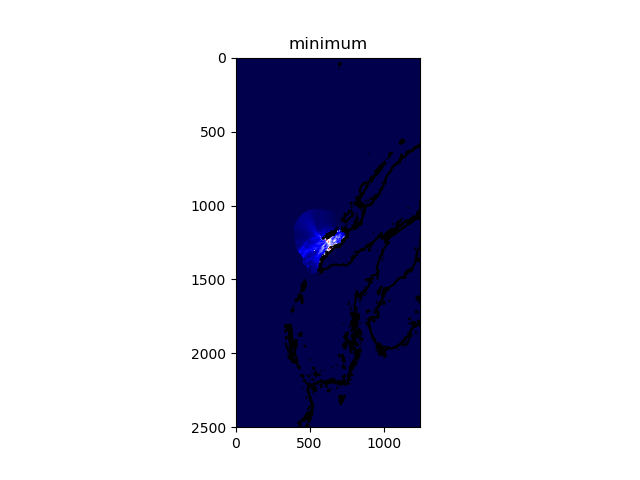

In [18]:
fig = plt.figure(126)
plt.title('minimum')
plt.imshow(1-minindo, cmap='seismic', norm=mpl.colors.LogNorm())
    # plt.colorbar()
plt.contour(ht-20, colors='black', levels=1)

plt.show()

# comparing indonesia sim to real data

In [19]:
import pandas as pd

ff = pd.read_csv('~rrs/shallowWater/data/2004indonesiarunups2.txt',sep='\t')
#with open('~rrs/shallowWater/data/2004indonesiarunups.txt','r') as f:
#     txt = f.read()
ff   

,Item,Item.1,Country,State,Name,Latitude,Longitude,DistanceFromSource,IWDay,IWHr,...,MWHr,MMWMin,MaxWaterHeight,MaxInundationDistance,Type,Per,1st,Mtn,z1,z2
0,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.43300,95.23600,245.0,NaN,NaN,...,NaN,NaN,26.10,NaN,5.0,NaN,NaN,NaN,NaN,NaN
1,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.56900,95.34100,257.0,NaN,NaN,...,NaN,NaN,6.10,NaN,5.0,NaN,NaN,NaN,NaN,NaN
2,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.60200,95.38300,260.0,NaN,NaN,...,NaN,NaN,10.70,NaN,5.0,NaN,NaN,NaN,NaN,NaN
3,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.61000,95.39700,260.0,NaN,NaN,...,NaN,NaN,11.00,NaN,5.0,NaN,NaN,NaN,NaN,NaN
4,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.28600,95.24400,229.0,NaN,NaN,...,NaN,NaN,11.10,NaN,5.0,NaN,NaN,NaN,NaN,NaN
5,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.64900,95.41600,264.0,NaN,NaN,...,NaN,NaN,4.20,NaN,5.0,NaN,NaN,NaN,NaN,NaN
6,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.64800,95.41500,264.0,NaN,NaN,...,NaN,NaN,4.90,NaN,5.0,NaN,NaN,NaN,NaN,NaN
7,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.62100,95.39800,261.0,NaN,NaN,...,NaN,NaN,6.00,NaN,5.0,NaN,NaN,NaN,NaN,NaN
8,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.64700,95.41500,264.0,NaN,NaN,...,NaN,NaN,7.00,NaN,5.0,NaN,NaN,NaN,NaN,NaN
9,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.64800,95.41500,264.0,NaN,NaN,...,NaN,NaN,7.10,NaN,5.0,NaN,NaN,NaN,NaN,NaN


In [20]:
# includes the whole world
allruns = pd.read_csv('~rrs/shallowWater/data/al2004indorunups2.txt', sep='\t')
allruns = allruns.dropna(how='any',subset=['Latitude', 'Longitude', 'TTHr', 'TTMin', 'MaxWaterHeight'])
allruns = allruns.loc[:,['Latitude','Longitude','MaxWaterHeight','DistanceFromSource','TTHr','TTMin','Name']]

In [21]:
# import data from file
indorut = pd.read_csv('~rrs/shallowWater/data/2004indonesiarunups2.txt',sep='\t')
indoevents = list(indorut.transpose().to_dict().values()) # list of dicts of events' properties
indoevents

[{'Item': '*',
  'Item.1': nan,
  'Country': 'INDONESIA ',
  'State': 'ACEH ',
  'Name': 'ACEH, SUMATRA ',
  'Latitude': 5.433,
  'Longitude': 95.236,
  'DistanceFromSource': 245.0,
  'IWDay': nan,
  'IWHr': nan,
  'IWMin': nan,
  'TTHr': nan,
  'TTMin': nan,
  'MWDay': nan,
  'MWHr': nan,
  'MMWMin': nan,
  'MaxWaterHeight': 26.1,
  'MaxInundationDistance': nan,
  'Type': 5.0,
  'Per': nan,
  '1st': nan,
  'Mtn': nan,
  'z1': nan,
  'z2': nan},
 {'Item': '* ',
  'Item.1': nan,
  'Country': 'INDONESIA ',
  'State': 'ACEH ',
  'Name': 'ACEH, SUMATRA ',
  'Latitude': 5.569,
  'Longitude': 95.341,
  'DistanceFromSource': 257.0,
  'IWDay': nan,
  'IWHr': nan,
  'IWMin': nan,
  'TTHr': nan,
  'TTMin': nan,
  'MWDay': nan,
  'MWHr': nan,
  'MMWMin': nan,
  'MaxWaterHeight': 6.1,
  'MaxInundationDistance': nan,
  'Type': 5.0,
  'Per': nan,
  '1st': nan,
  'Mtn': nan,
  'z1': nan,
  'z2': nan},
 {'Item': '* ',
  'Item.1': nan,
  'Country': 'INDONESIA ',
  'State': 'ACEH ',
  'Name': 'ACEH, SUM

In [22]:
# sort the events by proximity to the source
# indoevents.sort(key = lambda event: np.sqrt((indone2004.event['lat'] - event['Latitude'])**2 + (indone2004.event['lat'] - event['Longitude'])**2))
indoevents.sort(key = lambda event: event['DistanceFromSource'])

In [23]:
# simindomaxh = np.array([], dtype=np.float32) # the list of the maximum height that occured at each location
# for event in indoevents: # get the maximum water height at each location in the sim in the order given to us
# #     print(event)
#     evlat = event['Latitude'] # the latitude of the measurement
#     evlon = event['Longitude'] # "  longitude " "       "
#     argevlat = np.argmin(np.abs(indonesia.lat-evlat)) # the array index with latitude closest to point
#     argevlon = np.argmin(np.abs(indonesia.lon-evlon)) # the array index with longitude closest to point
#     mh = maxindo[argevlat, argevlon] # the maximum height at this point
#     if (argevlat == 0 or argevlon == 0): # if the point is out of the map so it just returns the edge
#         mh = 0 # ignore the value at the edge 
#     simindomaxh = np.append(simindomaxh, mh)

# list of indexes maximum height at the location of each event
# simindomaxh = [np.max(\
#                       maxindo[\
#                               np.argmin(np.abs(indonesia.lon-event['Longitude'])), \
#                               np.argmin(np.abs(indonesia.lat-event['Latitude']))]) \
#                for event in indoevents]
def simindomaxhgenerator():
    for event in indoevents:
        ilon = np.argmin(np.abs(indonesia.lon-event['Longitude']))
        ilat = np.argmin(np.abs(indonesia.lat-event['Latitude']))
        rad = 20
        ilon = np.max((ilon, rad))
        ilat = np.max((ilat, rad))
        
#         print(maxindo.shape, maxindo[ilon-rad:ilon+rad, ilat-rad:ilat+rad].shape, [ilon-rad,ilon+rad, ilat-rad,ilat+rad])
        try:
            mh = np.max(maxindo[ilon-rad:ilon+rad, ilat-rad:ilat+rad])
        except (ValueError): # when the section is entirely off the map so it returns an empty array
            mh = -1
        yield mh

simindomaxh = np.asarray(list(simindomaxhgenerator()))
simindomaxh

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.00000000e+00,
        0.00000000e+00, -1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -

In [24]:
indomaxheights = np.array([event['MaxWaterHeight'] for event in indoevents]) # the max water heights of each of the events in the order they are listed

In [25]:
#doesn't work - times not recorded
# indotimemh = [event['TTHr']*3600+event['TTMin']*60 for event in indoevents] # a 2d map of the time it took to get there
# indotimemh

<IPython.core.display.Javascript object>


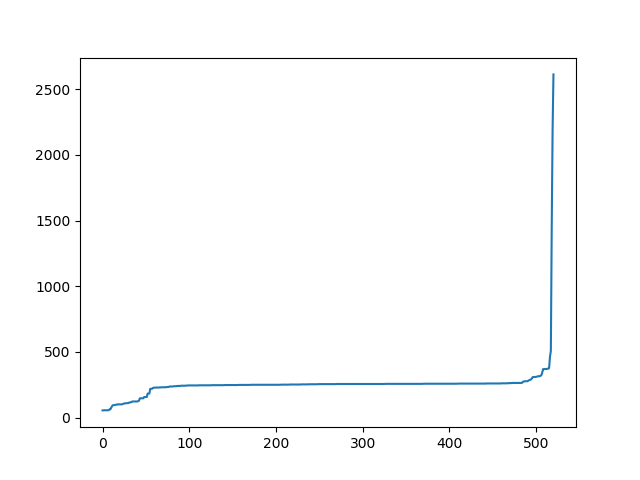

In [26]:
plt.figure(133)
plt.plot([event['DistanceFromSource'] for event in indoevents])
plt.show()

<IPython.core.display.Javascript object>


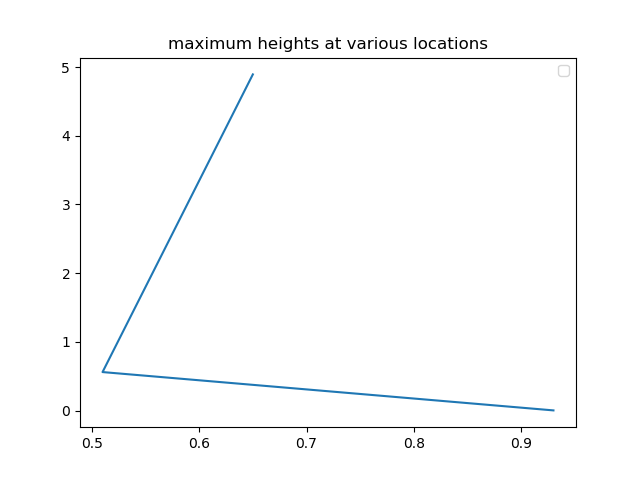

No handles with labels found to put in legend.


[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [27]:
plt.figure(236)
datamap = np.greater(simindomaxh, 0)
print(datamap)
plt.title('maximum heights at various locations')

plt.plot(indomaxheights[datamap], simindomaxh[datamap])

# plt.plot(indomaxheights[datamap], label='measurement') # real data of max water heights

# plt.plot(simindomaxh[datamap], label='simulation') # simulation max water heights in the same order

plt.legend()
plt.show()

# Palu event

In [ ]:
# class paluClass():
    
#     loc = (0, 120)# center of the simulation area
#     rad = (1, 1) # 'radius' half width of the simulation area in each direction
    
#     dlat = 111000 # latitude degree to meters
#     psize = (dlat*2*rad[0], dlat*2*rad[1]*np.cos(loc[0]*np.pi/180)) # physical size of area
#     size = (400, 400) # grid squares (dx)

#     dx = np.single(psize[1]/size[1], dtype=np.float32) # meters
#     dy = np.single(psize[0]/size[0], dtype=np.float32) # meters

    
#     bath = nc.Dataset('../data/bathymetry.nc','r')
    
#     trx = (np.argmin(np.abs(bath.variables['lat'][:]-loc[0]-rad[0])), np.argmin(np.abs(bath.variables['lon'][:]-loc[1]-rad[1])))
#     blx = (np.argmin(np.abs(bath.variables['lat'][:]-loc[0]+rad[0])), np.argmin(np.abs(bath.variables['lon'][:]-loc[1]+rad[1])))
#     latin = np.linspace(trx[0], blx[0], size[0], dtype=int) # lon 118, 122, lat -2, 2
#     lonin = np.linspace(trx[1], blx[1], size[1], dtype=int) # indexes of the bathymetry dataset we need
#     lat = bath.variables['lat'][latin]
#     lon = bath.variables['lon'][lonin]
#     h = np.asarray(-bath.variables['elevation'][latin, lonin], dtype=np.float32)[:, ::-1]
# #     h = 1000*np.ones(size, dtype=np.float32)
#     n = np.zeros(size)
    

#     u = np.zeros((size[0]+1, size[1]+0))
#     v = np.zeros((size[0]+0, size[1]+1))

In [261]:
def paluEvent(klass, elat, elon):
    pev = klass
#     pev = paluClass
    y = np.argmin(np.abs(pev.lat-elat))
    x = np.argmin(np.abs(pev.lon-elon))
    ry = 1+2*(int(25000/pev.dy)//2) # number of indicies across the disturbance is
    rx = 1+2*(int(25000/pev.dx)//2) # modified to be odd, so one point lands on tip og gaussian
    evpatch = pev.n[y-ry:y+ry, x-rx:x+rx].shape
    pev.n[y-ry:y+ry, x-rx:x+rx] = 10*planegauss((evpatch[0], evpatch[1]))
    full = np.sum(pev.n) # the total amount of initialy displaced water in the system
    pev.n[np.less(pev.h, 1.5*np.max(pev.n))] = 0#-pev.n[np.less(pev.h, 1.5*np.max(pev.n))]
    insea = np.sum(pev.n) # real displaced water, off of land
    pev.n *= full/(insea+1.0E-10) # normalize so all waves are equal even if partially on land
    pstate = State(*(props(vars(pev))))
    return pstate
# palu = paluEvent(**{'elat':-0.2, 'elon':120.4}) # palu, indonesia recent tsunami
# palu = State(*(props(vars(ev))))
def peventd(base, elat, elon):
    newn = np.array(dict(base)['n'])
    y = np.argmin(np.abs(base['lat']-elat))
    x = np.argmin(np.abs(base['lon']-elon))
    ry = 1+2*(int(25000/base['dy'])//2) # number of indicies across the disturbance is
    rx = 1+2*(int(25000/base['dx'])//2) # modified to be odd, so one point lands on tip of gaussian
    evpatch = newn[y-ry:y+ry, x-rx:x+rx].shape # mechanism to still work when partially offmap
    newn[y-ry:y+ry, x-rx:x+rx] = 10*planegauss((evpatch[0], evpatch[1]))
    
    full = np.sum(newn) # the total amount of initialy displaced water in the system
    newn[np.less(base['h'], 1.5*np.max(newn))] = 0 #get rid of water on land
    insea = np.sum(newn) # real displaced water, off of land
    newn *= full/(insea+1.0E-10) # normalize so all waves are equal even if partially on land
    return newn

In [278]:
palu = {}
latran = (-1.2, 1.2) # latitude range map covers
lonran = (118.2, 121.2) # longitude range map covers

# calculate height of map  11100*lat degrees = meters
# calculate width of map  1 lon degree = cos(lat) lat degrees, *11100 = meters
# use lon degree size of average latitude
realsize = (111000*(latran[1]-latran[0]),\
               111000*(lonran[1]-lonran[0])\
                  *np.cos((latran[1]-latran[0])/2))# h, w of map in meters

size = (500, 625) # grid size of the map lat, lon


palu['dx'] = np.single(realsize[1]/size[1], dtype=np.float32)
palu['dy'] = np.single(realsize[0]/size[0], dtype=np.float32)

# read in bathymetry data
bathdata = nc.Dataset('../data/bathymetry.nc','r')
bathlat = bathdata.variables['lat']
bathlon = bathdata.variables['lon']
#calculate indexes of bathymetry dataset we need
bathlatix = np.linspace(np.argmin(np.abs(bathlat[:]-latran[0])),\
                        np.argmin(np.abs(bathlat[:]-latran[1])),\
                        size[0], dtype=int)
bathlonix = np.linspace(np.argmin(np.abs(bathlon[:]-lonran[0])),\
                        np.argmin(np.abs(bathlon[:]-lonran[1])),\
                        size[1], dtype=int)
# print(bathlatix, bathlonix)
palu['h'] = np.asarray(-bathdata.variables['elevation'][bathlatix, bathlonix])
palu['lat'] = np.asarray(bathlat[bathlatix])
palu['lon'] = np.asarray(bathlon[bathlonix])

palu['n'] = np.zeros(size, dtype=np.float32)
palu['u'] = np.zeros((size[0]+1,size[1]), dtype=np.float32)
palu['v'] = np.zeros((size[0],size[1]+1), dtype=np.float32)

<IPython.core.display.Javascript object>


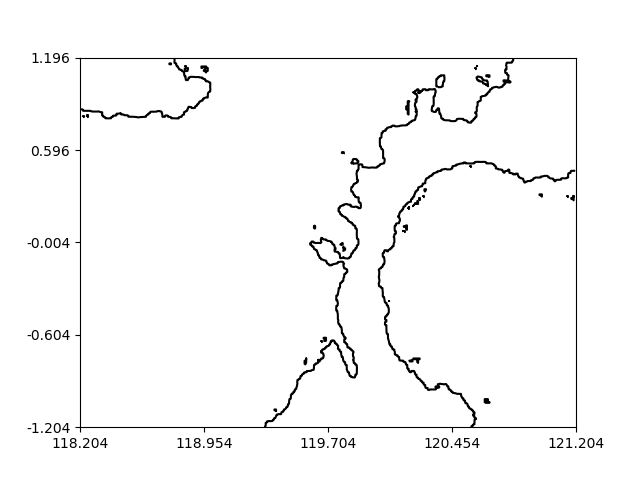

In [279]:

fig = plt.figure(167)
coast = plt.contour(palu['h'], levels=1, colors='black')
xtixks = plt.xticks(np.linspace(0, palu['h'].shape[1], 5),\
           np.round(np.linspace(palu['lon'][0], palu['lon'][-1], 5), 3))
yticks = plt.yticks(np.linspace(0, palu['h'].shape[0], 5),\
           np.round(np.linspace(palu['lat'][0], palu['lat'][-1], 5), 3))

In [34]:
# # seasurface = np.empty(qp.asnumpy(palu.n).shape)
# seasurface = qp.asnumpy(palu.n)
# bathymetry = -qp.asnumpy(palu.h)


# plt.figure(162)
# plt.title('initial conditions of indonesia simulation')

# # plt.subplot(121)
# a1 = plt.imshow(seasurface, cmap='seismic', vmin=-np.max(seasurface), vmax = np.max(seasurface))
# tt1 = plt.title('initial sea surface height with traced coastline')
# cb1 = plt.colorbar()
# cb1.set_label('sea surface height (m)')

# # plt.subplot(222)
# a2 = plt.contour(bathymetry+15, levels=1, colors='black')


# # plt.subplot(122)
# # # a3 = vect()
# # tt3 = plt.title('inital velocity (m/s)')

In [168]:
# palusim = simulate(palu, 2000)

/home/rrs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in sqrt
/home/rrs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in sqrt



simulation finished


In [144]:
# # palut, maxpalu, minpalu, tmpalu = palusim[:4]
# palut = palusim['frames']
# maxpalu = palusim['max']
# minpalu = palusim['min']
# timepalu = palusim['time']

(120, 400, 400)
(120,)


<IPython.core.display.Javascript object>


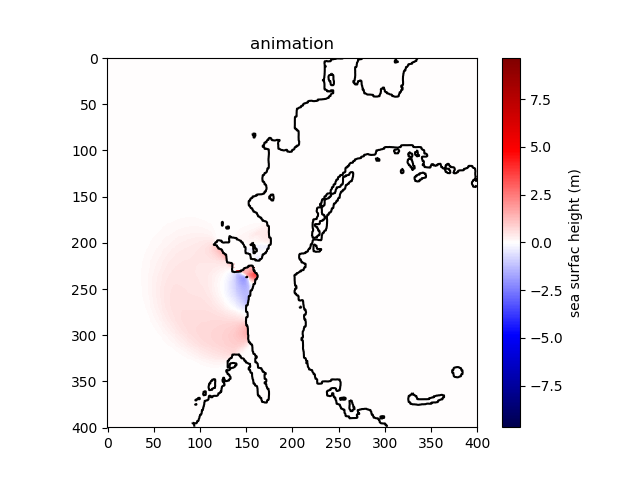

<IPython.core.display.Javascript object>


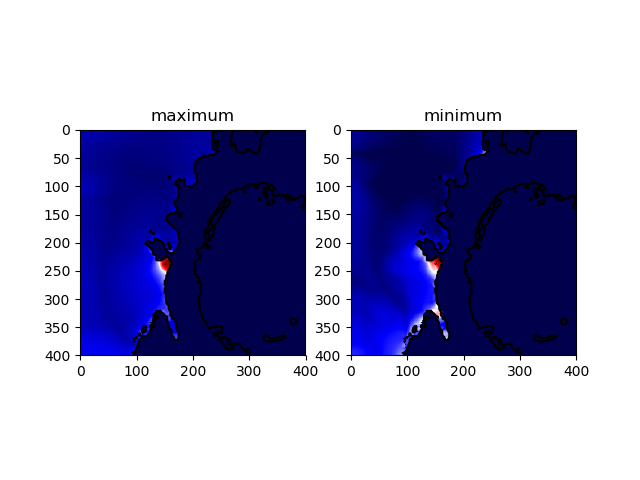

In [145]:
# paluf = np.transpose(palut, (0, 1, 2))
# print(paluf.shape)
# maxt = np.max(paluf,axis=(1,2))
# print(maxt.shape)
# imaxt = np.float32(1.0/maxt)
# # plt.figure(888)
# # plt.semilogy(maxt)

# # plt.show()
# norm_paluf = paluf*imaxt[:,np.newaxis,np.newaxis]

# fig = plt.figure(168)
# ttl = plt.title('animation')
# pmax = np.max([np.max(palut), -np.min(palut)])/2
# f = [(plt.imshow(pframe, cmap='seismic', vmin=-pmax, vmax=pmax),) for pframe in palut]
# # f = genframes(norm_paluf*0.3)#, frames=np.linspace(0, norm_paluf.shape[0]-1, 300, dtype=int))
# anim = animation.ArtistAnimation(fig, f)
# cb = plt.colorbar()
# cb.set_label('sea surfac height (m)')
# h = qp.asnumpy(palu.h)
# # ht = np.transpose(h)
# ht = h
# coast = plt.contour(ht-20, colors='black', levels=1)


# fig = plt.figure(170)
# plt.subplot(1, 2, 1)
# plt.title('maximum')
# plt.imshow(maxpalu+1, cmap='seismic', norm=mpl.colors.LogNorm())
# # plt.colorbar()
# plt.contour(ht-20, colors='black', levels=1)

# plt.subplot(1, 2, 2)
# plt.title('minimum')
# plt.imshow(1-minpalu, cmap='seismic', norm=mpl.colors.LogNorm())
# # plt.colorbar()
# plt.contour(ht-20, colors='black', levels=1)

# plt.show()

In [94]:
# anim.save('../data/palu1.mp4')

<IPython.core.display.Javascript object>


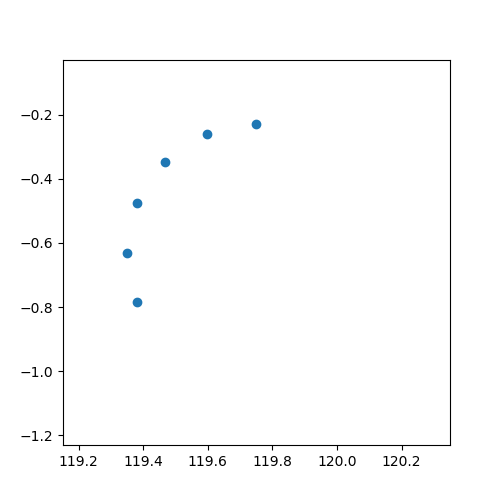

<IPython.core.display.Javascript object>


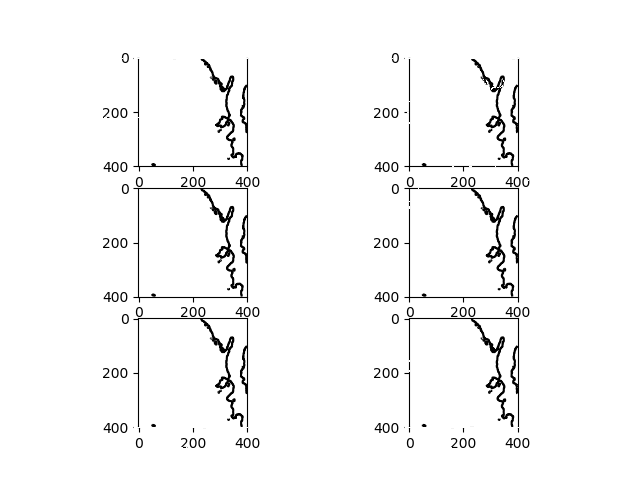

In [280]:

eventcount = 6
center = (-0.63,119.75)
events = np.array([center])
rad = 0.4 # latitude degrees
theta = np.pi/2
for ev in range(eventcount):
    events = np.vstack( ( events, (np.sin(theta)*rad+center[0], np.cos(theta)*rad+center[1]) ) )
    theta += np.pi/8
events = events[1:] #get rid of the made up start point
plt.figure(172, figsize=(5, 5))

plt.scatter(events[:,1], events[:,0])
# plt.contour(palu.h, levels=1, colors='black')

plt.ylim(center[0]-1.5*rad, center[0]+1.5*rad)
plt.xlim(center[1]-1.5*rad, center[1]+1.5*rad)


fig = plt.figure(174)
coast = plt.contour(palu['h'], levels=1, colors='black')
xtixks = plt.xticks(np.linspace(0, palu['h'].shape[1], 5),\
           np.round(np.linspace(palu['lon'][0], palu['lon'][-1], 5), 3))
yticks = plt.yticks(np.linspace(0, palu['h'].shape[0], 5),\
           np.round(np.linspace(palu['lat'][0], palu['lat'][-1], 5), 3))


In [290]:
displays = np.array([{}])
eventnum = 0
for event in events:
    evinit = dict(palu)
    evinit['n'] = peventd(evinit, *event)
    paluEventState = State(**evinit)#paluEvent(State(**dict(palu)), *event) # generates initial state a the event location
    displays = np.append(displays, {})
    
    displays[eventnum]['initial'] = paluEventState.n
    
    paluEventSim = simulate(paluEventState, 3000)
    print('finished event ' + str(eventnum))
    displays[eventnum]['animation'] = paluEventSim['frames']
    displays[eventnum]['max'] = paluEventSim['max']
    displays[eventnum]['min'] = paluEventSim['min']
    eventnum += 1

timestep #:122


Exception: error occured in simulate, printed timestep#

In [82]:
np.save('palueventsarray', displays)

MemoryError: 

<IPython.core.display.Javascript object>


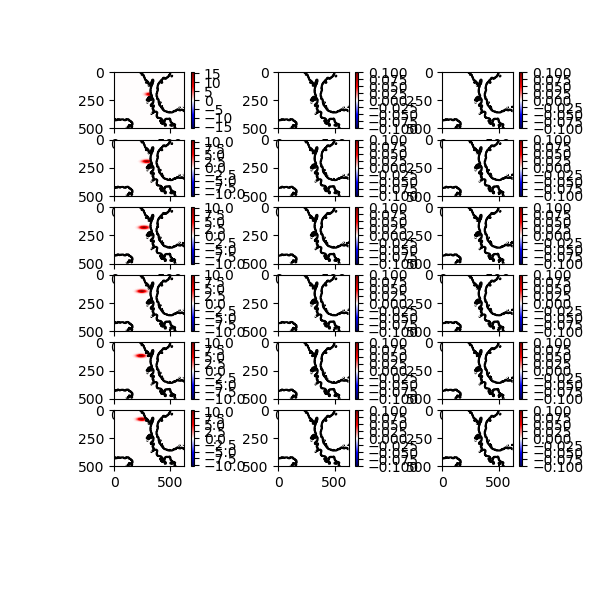

/home/rrs/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [289]:
height = 3#len(displays[0].keys()-1)
width = len(displays)
fig = plt.figure(figsize=(6,6))

displaynum = 1
for display in displays[:-1]:
    for dispty in [display[k] for k in ['initial', 'max', 'min']]:
        plt.subplot(width, height, displaynum)
        mmax = np.max(np.abs(dispty))
        plt.imshow(dispty, cmap='seismic', vmin=-mmax)
        plt.colorbar()
        plt.contour(palu['h'], levels=1, colors='black')
        displaynum += 1

/home/rrs/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<IPython.core.display.Javascript object>


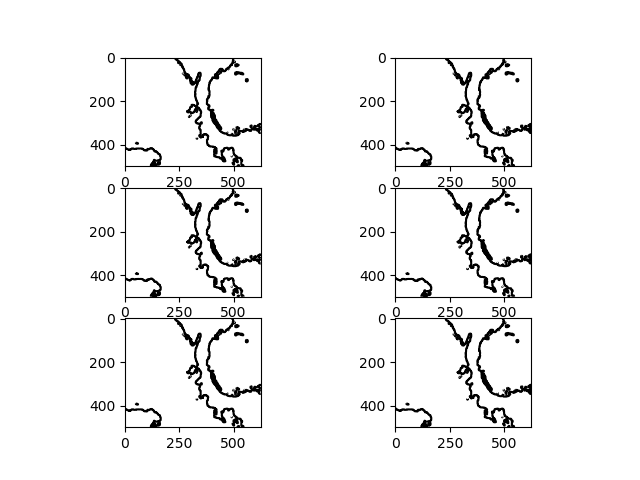

<IPython.core.display.Javascript object>


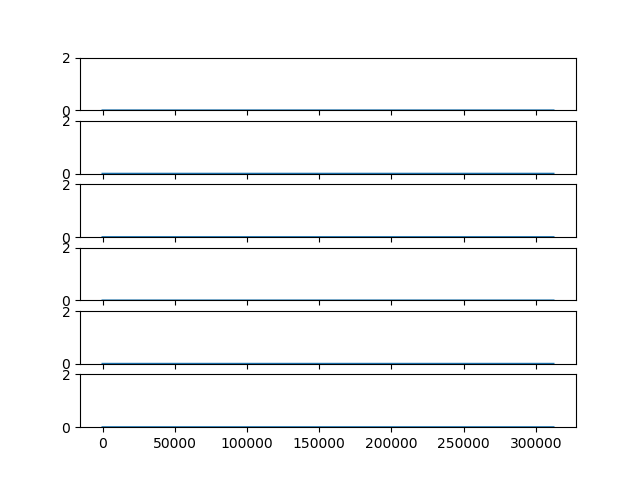

In [288]:

palutr = (0, 0)
palubl = (400, 400) # palu bay section indices
# disptrans = {}
devinit = [k['initial'] for k in displays[:-1]]
devmax = np.array([k['max'] for k in displays[:-1]])#list of max heights in each simulation
devmin = np.array([k['min'] for k in displays[:-1]])
# print(palutr[1],palubl[1])
paldevmin = devmin[:,palutr[0]:palubl[0],palutr[1]:palubl[1]]
paldevmax = devmax[:,palutr[0]:palubl[0],palutr[1]:palubl[1]]
# normalize to max and min of palu bay section only
pmax = np.max([np.abs(paldevmin), np.abs(paldevmax)])

displaynum = 1
plt.figure(176)
for display in displays[:-1]:
    plt.subplot(3, 2, displaynum)
    maxdata = display['max']/2
    plt.imshow(maxdata, cmap='nipy_spectral')#, cmap='seismic', vmin=-pmax, vmax=pmax)
#     plt.colorbar()
    coast = plt.contour(paluEventState.h-16, levels=1, colors='black')
    displaynum +=1

    
displaynum = 1
plt.figure(177)
for display in displays[:-1]:
    plt.subplot(6, 1, displaynum)
    maxdata = display['max']/2
#     plt.imshow(maxdata, cmap='seismic', vmin=-pmax, vmax=pmax)
    plt.plot(maxdata[np.where(paluEventState.h-21)]==0)
#     plt.colorbar()
    plt.ylim(0, 2)
#     coast = plt.contour(paluEventState.h[palutr[0]:palubl[0], palutr[1]:palubl[1]]-16, levels=1, colors='black')
    displaynum +=1
    

# fignum = 178
# displaynum = 0
# for display in displays[:-1]:
# #     print(display.keys())
#     fig = plt.figure(fignum + displaynum)
#     plt.title(str(displaynum))
    
#     ax1 = fig.add_subplot(2, 2, 1) # initial SSH
#     plt.title('initial ssh')
#     initssh = display['initial']
    
#     plt.imshow(initssh, cmap='seismic', vmin=-pmax, vmax=pmax)
#     coast = plt.contour(paluEventState.h-15, levels=1, colors='black')
    
#     ax3 = fig.add_subplot(2, 2, 3)
#     plt.title('max')
#     maxdata = display['max'][palutr[0]:palubl[0], palutr[1]:palubl[1]]/2
#     plt.imshow(maxdata, cmap='seismic', vmin=-pmax, vmax=pmax)
#     plt.colorbar()
#     coast = plt.contour(paluEventState.h[palutr[0]:palubl[0], palutr[1]:palubl[1]]-15 , levels=1, colors='black')
    
#     ax4 = fig.add_subplot(2, 2, 4)
#     plt.title('min')
#     mindata = display['min'][palutr[0]:palubl[0], palutr[1]:palubl[1]]/2
#     plt.imshow(mindata, cmap='seismic', vmin=-pmax, vmax=pmax)
#     plt.colorbar()
#     coast = plt.contour(paluEventState.h[palutr[0]:palubl[0], palutr[1]:palubl[1]]-15, levels=1, colors='black')
    
#     ax2 = fig.add_subplot(2, 2, 2)
#     displaynum += 1
#     fig = plt.figure(fignum + displaynum)
#     plt.title('animation')
#     frames = display['animation']
#     mmax = np.max(np.abs(frames))/2
#     artis = [(plt.imshow(pframe, cmap='seismic', vmin=-pmax, vmax=pmax),) for pframe in frames]
#     anim = animation.ArtistAnimation(fig, artis)
#     coast = plt.contour(paluEventState.h-15, levels=1, colors='black')
#     anim.save('../results/paluev'+str(displaynum)+'.mp4')
    
    
    
#     displaynum += 1